Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, roc_auc_score, 
                             mean_absolute_error, mean_squared_error, r2_score, classification_report)

import xgboost as xgb

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings('ignore')

df_class = pd.read_csv('../data/classification-train.csv')
df_reg = pd.read_csv('../data/boston-regression.csv')

X_cls = df_class.drop('price_range', axis=1)
y_cls = df_class['price_range']
X_reg = df_reg.drop('MEDV', axis=1)
y_reg = df_reg['MEDV']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

def print_metrics(y_true, y_pred, y_proba=None, task='classification', model_name='Model'):
    print(f"--- {model_name} ---")
    if task == 'classification':
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}")
        return acc
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        print(f"RMSE: {rmse:.4f} | R2: {r2:.4f}")
        return r2

## Бейзлайн
Даже с параметрами по умолчанию показывает хорошие результаты, но сам бустинг более склонен к переобучению, если деревьев слишком много, а learning_rate высокий, так что если тюнить, то аккуратно

In [2]:
# --- Классификация ---
gb_cls = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_cls.fit(X_train_c, y_train_c)
y_pred_c_gb = gb_cls.predict(X_test_c)

# --- Регрессия ---
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_reg.fit(X_train_r, y_train_r)
y_pred_r_gb = gb_reg.predict(X_test_r)

acc_gb = print_metrics(y_test_c, y_pred_c_gb, task='classification', model_name='Sklearn GBM (Class)')
r2_gb = print_metrics(y_test_r, y_pred_r_gb, task='regression', model_name='Sklearn GBM (Reg)')

--- Sklearn GBM (Class) ---
Accuracy: 0.9050 | F1: 0.9055
--- Sklearn GBM (Reg) ---
RMSE: 2.4918 | R2: 0.9153


## Тюнинг бейзлайна
будем использовать XGBoost. Он быстрее, поддерживает параллелизацию, регуляризацию и работу с пропусками\
и подберем гиперпараметры - нам надо поймать баланс между learning_rate и n_estimators

In [4]:
xgb_cls = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', seed=42)
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.7, 1.0]
}

# --- Class ---
grid_xgb_cls = GridSearchCV(xgb_cls, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb_cls.fit(X_train_c, y_train_c)

# --- Reg ---
grid_xgb_reg = GridSearchCV(xgb_reg, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_xgb_reg.fit(X_train_r, y_train_r)

print(f"Best Params (Class): {grid_xgb_cls.best_params_}")
print(f"Best Score (Class): {grid_xgb_cls.best_score_:.4f}")
print(f"Best Params (Reg): {grid_xgb_reg.best_params_}")
print(f"Best Score (Reg): {grid_xgb_reg.best_score_:.4f}")

Best Params (Class): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
Best Score (Class): 0.9087
Best Params (Reg): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
Best Score (Reg): 0.8487


Посмотрим важность признаков и заметим, что в очередной раз те же признаки, то и раньше доминируют над остальными. Однако в датасете Boston уровень население ушел на третье место и вместо него на втором оказался уровень преступности

--- XGBoost Tuned ---
Accuracy: 0.9150 | F1: 0.9151
--- XGBoost Tuned ---
RMSE: 2.4279 | R2: 0.9196


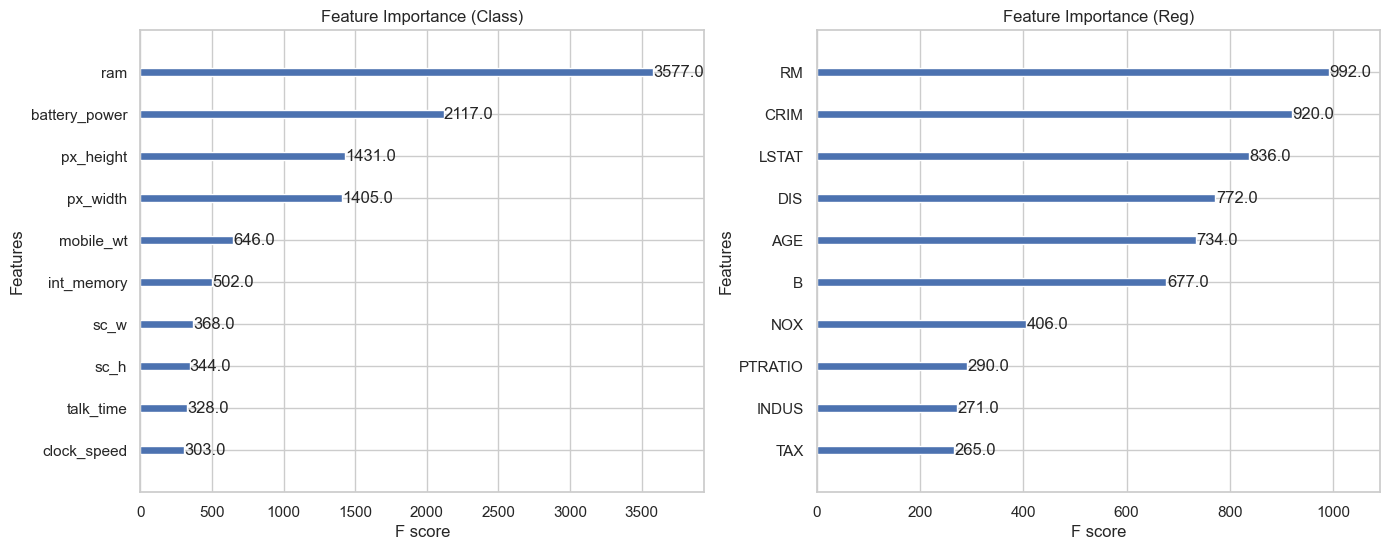

In [5]:
best_xgb_cls = grid_xgb_cls.best_estimator_
best_xgb_reg = grid_xgb_reg.best_estimator_

y_pred_c_xgb = best_xgb_cls.predict(X_test_c)
y_pred_r_xgb = best_xgb_reg.predict(X_test_r)

print_metrics(y_test_c, y_pred_c_xgb, task='classification', model_name='XGBoost Tuned')
print_metrics(y_test_r, y_pred_r_xgb, task='regression', model_name='XGBoost Tuned')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
xgb.plot_importance(best_xgb_cls, ax=ax[0], max_num_features=10, title='Feature Importance (Class)')
xgb.plot_importance(best_xgb_reg, ax=ax[1], max_num_features=10, title='Feature Importance (Reg)')
plt.show()

## Самостоятельная реализация
Реализуем Gradient Boosting Regressor для MSE (L2 loss). Градиент функции потерь L(y, y') = 1/2 * (y - y')^2 по предсказаниб равен -(y - y') => антигридиент - это остатки (y - y')\
И, как видим по результатам, наш кастомный бустинг оказался очень близок к библиотечному, даже лучше

In [10]:
from sklearn.tree import DecisionTreeRegressor

class CustomGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.trees = []
        
        self.initial_prediction = np.mean(y)
        y_pred = np.full(y.shape, self.initial_prediction)
        
        for _ in range(self.n_estimators):
            residuals = y - y_pred
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            
    def predict(self, X):
        X = np.array(X)
        y_pred = np.full(X.shape[0], self.initial_prediction)
        
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
            
        return y_pred

custom_gb = CustomGradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=7)
custom_gb.fit(X_train_r, y_train_r)
y_pred_custom = custom_gb.predict(X_test_r)

print("--- Custom Gradient Boosting (Regression) ---")
print(f"R2 Score: {r2_score(y_test_r, y_pred_custom):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_custom)):.4f}")

--- Custom Gradient Boosting (Regression) ---
R2 Score: 0.9336
RMSE: 2.2060


## Сравнение всех алгоритмов
данные для других моделей берем из предыдущих лаб\
KNN - (acc = 0.94, r2 = 0.77)\
LogReg - (acc = 0.88, r2 = 0.85)\
DecTree - (acc = 0.83, r2 =	0.88)\
RandForest - (acc = 0.9	r2 = 0.89)

In [11]:
final_results = {
    'Algorithm': [
        'KNN (Lab 1)', 
        'Log/Lin Reg (Lab 2)', 
        'Decision Tree (Lab 3)', 
        'Random Forest (Lab 4)', 
        'XGBoost (Lab 5)'
    ],
    'Classification Accuracy': [
        0.94,
        0.88,
        0.83,
        0.90,
        accuracy_score(y_test_c, y_pred_c_xgb)
    ],
    'Regression R2 Score': [
        0.77,
        0.85,
        0.88,
        0.89,
        r2_score(y_test_r, y_pred_r_xgb) # XGBoost
    ]
}

df_final = pd.DataFrame(final_results)

df_final = df_final.sort_values('Regression R2 Score', ascending=True)

display(df_final)

,Algorithm,Classification Accuracy,Regression R2 Score
0,KNN (Lab 1),0.940,0.770000
1,Log/Lin Reg (Lab 2),0.880,0.850000
2,Decision Tree (Lab 3),0.830,0.880000
3,Random Forest (Lab 4),0.900,0.890000
4,XGBoost (Lab 5),0.915,0.919621


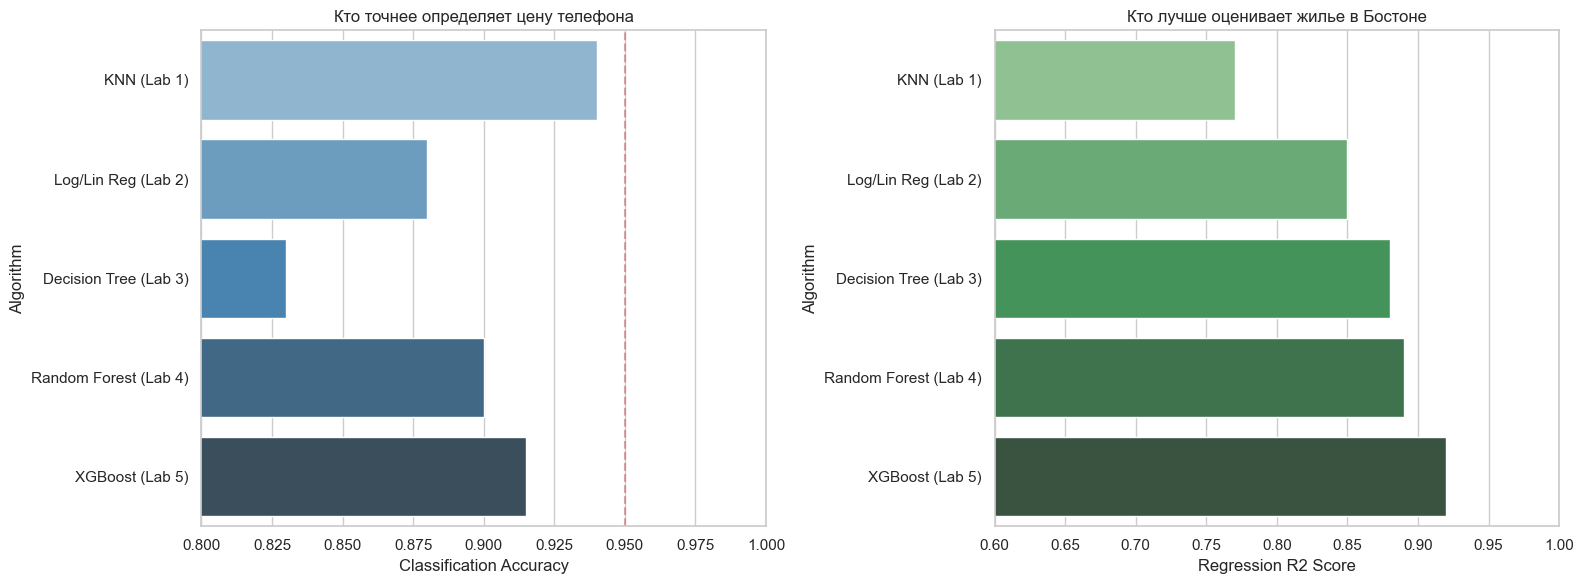

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

colors_c = sns.color_palette("Blues_d", len(df_final))
sns.barplot(x='Classification Accuracy', y='Algorithm', data=df_final, ax=ax[0], palette=colors_c)
ax[0].set_title('Кто точнее определяет цену телефона')
ax[0].set_xlim(0.8, 1.0)
ax[0].axvline(0.95, color='r', linestyle='--', alpha=0.5, label='95% threshold')

colors_r = sns.color_palette("Greens_d", len(df_final))
sns.barplot(x='Regression R2 Score', y='Algorithm', data=df_final, ax=ax[1], palette=colors_r)
ax[1].set_title('Кто лучше оценивает жилье в Бостоне')
ax[1].set_xlim(0.6, 1.0)

plt.tight_layout()
plt.show()

## Итоги
1. Лучшая модель для Классификации цены телефонов\
  - KNN на первром месте, XGBoost с небольшим отставанием на втором и Rand Forest на третьем\
2. Лучшая модель для Регрессии цены жилья в Бостоне\
  - XGBoost на первои месте, Rand Forest на втором и близко к нему Dec Tree\
  - Возможно одна из причин такого рейтинга заключается в том, что датасет сложный, маленький и содержит нелинейные зависимости (тот же LSTAT) => линейная регрессия (без полиномов) проваливается, а деревья и ансамбли наоборот отлично моделируют сложную структуру\
  - XGBoost выйграл на пару процентов у леса за счет последовательного исправления ошибок, хоть он и требует более тщательной настройки learning_rate\